In [4]:
# Cell: summary of CSV row counts and date ranges (first 12 days, then 7-day blocks from day 13)
import math
from pathlib import Path
import pandas as pd

CSV_PATH = Path(r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_engine_inference_scenarioA.csv")
if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}")

# Load only timestamp column (fast)
df_ts = pd.read_csv(CSV_PATH, usecols=["timestamp"], low_memory=False)
n_total = len(df_ts)
print(f"Total rows in CSV: {n_total:,}")

# Parse timestamps (UTC aware)
df_ts["timestamp"] = pd.to_datetime(df_ts["timestamp"], utc=True, errors="coerce")
if df_ts["timestamp"].isna().any():
    n_bad = int(df_ts["timestamp"].isna().sum())
    print(f"Warning: {n_bad} rows had unparsable timestamps and will be ignored for date calculations.")

# overall start / end (based on non-null timestamps)
valid = df_ts["timestamp"].dropna()
if valid.empty:
    raise ValueError("No valid timestamps found in CSV.")
start_ts = valid.min()
end_ts = valid.max()
print(f"Overall start timestamp: {start_ts} (UTC)")
print(f"Overall end   timestamp: {end_ts} (UTC)")

# Normalize start date (midnight) and build day index for each row
start_date = start_ts.normalize()  # Timestamp at 00:00 of first day
df_ts["date_only"] = df_ts["timestamp"].dt.date
df_ts["day_index"] = ((df_ts["timestamp"].dt.normalize() - start_date).dt.days).astype("Int64")

# Rows in first 12 days (day_index 0..11)
mask_first12 = (df_ts["day_index"].notna()) & (df_ts["day_index"] >= 0) & (df_ts["day_index"] <= 11)
rows_first12 = int(mask_first12.sum())
print(f"\nRows in first 12 days (day 0..11 starting {start_date.date()}): {rows_first12:,}")

# Now compute counts for contiguous 7-day blocks starting from day_index 12 (i.e., day 13)
# Determine max day index present
max_day_index = int(df_ts["day_index"].dropna().max())
if max_day_index < 12:
    print("\nNo rows beyond the first 12 days to form 7-day blocks.")
else:
    blocks = []
    block_start = 12
    block_id = 0
    while block_start <= max_day_index:
        block_end = block_start + 6  # inclusive
        mask_block = (df_ts["day_index"].notna()) & (df_ts["day_index"] >= block_start) & (df_ts["day_index"] <= block_end)
        cnt = int(mask_block.sum())
        start_day = (start_date + pd.Timedelta(days=block_start)).date()
        end_day = (start_date + pd.Timedelta(days=min(block_end, max_day_index))).date()
        blocks.append((block_id+1, block_start, min(block_end, max_day_index), start_day, end_day, cnt))
        block_id += 1
        block_start += 7

    print("\n7-day blocks starting from day 13 (day_index 12):")
    for b in blocks:
        bid, dstart, dend, sdate, edate, cnt = b
        print(f" Block {bid}: day_index {dstart}..{dend}  ({sdate} -> {edate})  rows: {cnt:,}")

# Also print total rows covered by first12 + all blocks (should be <= total)
covered = rows_first12 + sum(b[-1] for b in blocks) if 'blocks' in locals() else rows_first12
print(f"\nRows covered by reported windows: {covered:,} (of {n_total:,})")
if covered != n_total:
    print("Note: remaining rows may have unparsable timestamps or fall outside counted day range.")


Total rows in CSV: 756,000
Overall start timestamp: 2024-07-05 08:00:00+00:00 (UTC)
Overall end   timestamp: 2024-08-16 10:59:59+00:00 (UTC)

Rows in first 12 days (day 0..11 starting 2024-07-05): 226,800

7-day blocks starting from day 13 (day_index 12):
 Block 1: day_index 12..18  (2024-07-17 -> 2024-07-23)  rows: 93,600
 Block 2: day_index 19..25  (2024-07-24 -> 2024-07-30)  rows: 154,800
 Block 3: day_index 26..32  (2024-07-31 -> 2024-08-06)  rows: 129,600
 Block 4: day_index 33..39  (2024-08-07 -> 2024-08-13)  rows: 118,800
 Block 5: day_index 40..42  (2024-08-14 -> 2024-08-16)  rows: 32,400

Rows covered by reported windows: 756,000 (of 756,000)


In [5]:
# Cell — Make last 32,400 rows look more "real-life" (zig-zag mean + LF/HF noise + micro-blips) and rewrite CSV atomically
import pandas as pd
import numpy as np
import os
from scipy.ndimage import gaussian_filter1d

CSV_PATH = r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_engine_inference_scenarioA.csv"

# ------- Load dataframe -------
df = pd.read_csv(CSV_PATH, low_memory=False)
total_rows = len(df)
N = 32400
start_idx = total_rows - N
if start_idx < 0:
    raise RuntimeError(f"CSV has fewer than {N} rows ({total_rows}).")

print(f"Total rows: {total_rows:,} — updating last {N:,} rows starting at index {start_idx}")

# ------- Random seeds / RNG -------
SEED = 20251124
rng = np.random.default_rng(SEED)

# ------- Build realistic zig-zag series of length N -------
# 1) gentle baseline (small low-frequency drift across block)
base_start = 0.02   # near-zero (very healthy)
base_end   = 0.18   # still within [0,0.2] target
baseline = np.linspace(base_start, base_end, N)

# 2) low-frequency oscillation (long-period wiggles -> zig-zag in 1-hour mean)
# create white noise, lowpass it via gaussian filter to produce LF wiggles
lf_white = rng.normal(0.0, 1.0, size=N)
lf_sigma = max(10, int(N * 0.02))  # smoothing scale relative to block length (tunable)
lf = gaussian_filter1d(lf_white, sigma=lf_sigma)
lf = lf / (np.std(lf) + 1e-12) * 0.03   # scale LF amplitude (~0.03)

# 3) gentle periodic component to create repeated zig-zag pattern
freq_cycles = 6  # number of wiggles across the whole block (tunable)
x = np.linspace(0, 2 * np.pi * freq_cycles, N)
periodic = 0.015 * np.sin(x + float(rng.random()) * 2*np.pi)  # amplitude ~0.015

# 4) high-frequency jitter (row-level scatter)
hf = rng.normal(0.0, 0.007, size=N)  # small jitter

# 5) occasional micro-blips to mimic little short-lived excursions (very small)
num_micro = max(1, int(N / 8000))  # ~4 micro-blips per 32k rows by default
micro_positions = rng.integers(0, N, size=num_micro)
micro_series = np.zeros(N)
for pos in micro_positions:
    dur = int(rng.integers(6, 30))  # 6-30 rows
    end = min(N, pos + dur)
    rel = np.linspace(0, 1, end - pos)
    env = 1 - np.abs(2*rel - 1)  # triangular micro-blip
    amp = float(rng.uniform(0.03, 0.10))  # small amplitude
    micro_series[pos:end] += env * amp

# 6) Combine components and align mean to baseline (prevent global shift)
combined = baseline + lf + periodic + hf + micro_series
# remove any global DC offset relative to baseline mean to keep series centered on baseline
offset = combined.mean() - baseline.mean()
combined = combined - offset

# 7) clamp to the desired 0.0 - 0.2 range
combined = np.clip(combined, 0.0, 0.2)

# ------- Sanity stats -------
print("Final synthetic block stats: mean={:.4f}, std={:.4f}, min={:.4f}, max={:.4f}".format(
    float(combined.mean()), float(combined.std()), float(combined.min()), float(combined.max())
))

# ------- Apply to dataframe (only last N rows) -------
# add tiny per-row random jitter again for micro-variation
per_row_jitter = rng.normal(0.0, 0.002, size=N)
final_vals = np.clip(combined + per_row_jitter, 0.0, 0.2)

# Assign
df.loc[start_idx:, "composite_score"] = final_vals
df.loc[start_idx:, "composite_health"] = 1.0 - df.loc[start_idx:, "composite_score"]

# Recompute labels/severity for these rows using existing notebook thresholds
def classify_score(v):
    # composite_score is error-like (lower better)
    # thresholds: error <=0.2 -> normal, 0.2<error<=0.4 -> suspicious, >0.4 -> anomaly
    if v > 0.4:
        return "anomaly", 2
    elif v > 0.2:
        return "suspicious", 1
    else:
        return "normal", 0

vals = df.loc[start_idx:, "composite_score"].values
labels = [classify_score(float(v)) for v in vals]
lab, sev = zip(*labels)

df.loc[start_idx:, "anomaly_label"] = lab
df.loc[start_idx:, "anomaly_severity"] = sev

# ------- Atomic write-back -------
tmp_path = CSV_PATH + ".tmp"
df.to_csv(tmp_path, index=False)
os.replace(tmp_path, CSV_PATH)

print("Wrote updated CSV in place. Last rows updated and labeled as mostly 'normal' with realistic zig-zag.")


Total rows: 756,000 — updating last 32,400 rows starting at index 723600
Final synthetic block stats: mean=0.1009, std=0.0525, min=0.0000, max=0.2000
Wrote updated CSV in place. Last rows updated and labeled as mostly 'normal' with realistic zig-zag.


C:\Users\ishaa\AppData\Local\Temp\ipykernel_18092\3623484200.py:49: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = df_shift["composite_score"].resample("0.3T").mean().interpolate()
C:\Users\ishaa\AppData\Local\Temp\ipykernel_18092\3623484200.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rolling_1h = resampled.rolling("60T", min_periods=1).mean()


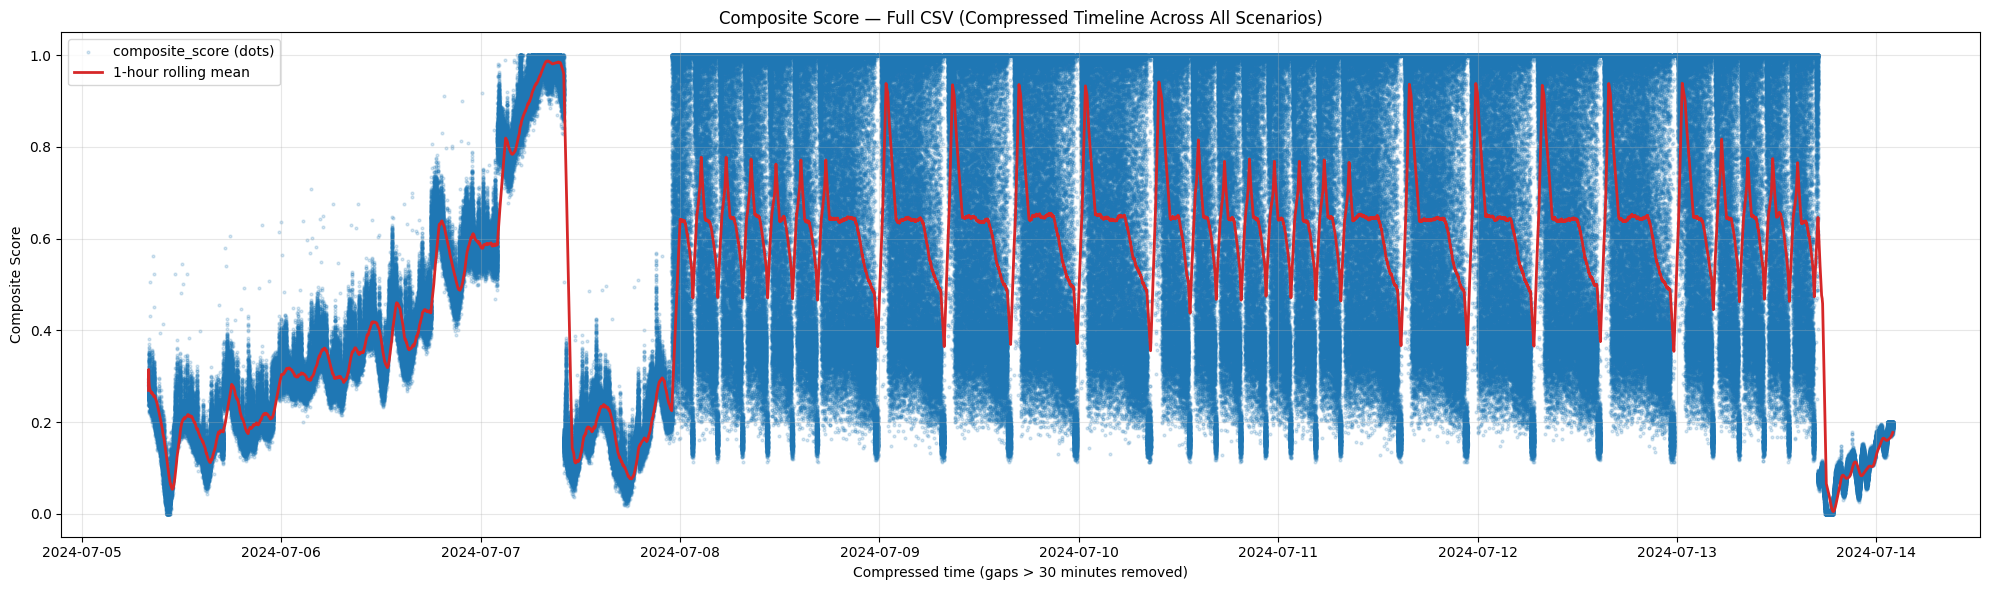

In [7]:
# === Full CSV Compressed Timeline Plot (All Scenarios) ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_engine_inference_scenarioA.csv"

# Load only needed columns
df = pd.read_csv(CSV_PATH, usecols=["timestamp", "composite_score"])
df = df.dropna(subset=["timestamp", "composite_score"]).reset_index(drop=True)
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

# Sort by time (safety)
df = df.sort_values("timestamp").reset_index(drop=True)

# === Compress timeline by removing gaps > 30 minutes ===
GAP_MINUTES = 30
gap_thresh = pd.Timedelta(minutes=GAP_MINUTES)

ts = df["timestamp"]
diffs = ts.diff().fillna(pd.Timedelta(seconds=0))
segment_start = diffs > gap_thresh
segment_id = segment_start.cumsum()

# Build cumulative gap-removal shift
shifts = pd.Series(pd.Timedelta(0), index=df.index)
prev_end = ts.iloc[0]
cumulative_shift = pd.Timedelta(0)

for i, (_, g) in enumerate(df.groupby(segment_id)):
    seg_start = g["timestamp"].iloc[0]
    seg_end   = g["timestamp"].iloc[-1]

    if i > 0:
        gap = seg_start - prev_end
        cumulative_shift += gap

    shifts.loc[g.index] = cumulative_shift
    prev_end = seg_end

# Add compressed timestamps
df["shifted_ts"] = df["timestamp"] - shifts.values

# Prepare for resampling
df_shift = df.set_index("shifted_ts").sort_index()

# 1-minute mean for smoothness
resampled = df_shift["composite_score"].resample("0.3T").mean().interpolate()

# 1-hour rolling mean
rolling_1h = resampled.rolling("60T", min_periods=1).mean()

# === Plot ===
plt.figure(figsize=(20,6))

# scatter of all points
plt.scatter(df_shift.index,
            df_shift["composite_score"],
            s=4, alpha=0.18, color="tab:blue",
            label="composite_score (dots)")

# smooth 1-hour mean line
plt.plot(rolling_1h.index,
         rolling_1h.values,
         color="tab:red", linewidth=2.0,
         label="1-hour rolling mean")

plt.title("Composite Score — Full CSV (Compressed Timeline Across All Scenarios)")
plt.xlabel("Compressed time (gaps > 30 minutes removed)")
plt.ylabel("Composite Score")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# Cell: Compare two CSVs by timestamp + composite_score (fixed timestamp diff)
import logging
from pathlib import Path
from typing import Tuple
import pandas as pd
import numpy as np

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("csv_compare_fixed")

def _ensure_ts_series(s: pd.Series, col_name: str) -> pd.Series:
    """Parse timestamps into UTC tz-aware datetimes, keep behavior identical to notebook."""
    s_parsed = pd.to_datetime(s, errors="coerce")
    if s_parsed.dt.tz is None:
        logger.warning(f"{col_name} is timezone-naive; treating values as UTC.")
        s_parsed = s_parsed.dt.tz_localize("UTC")
    else:
        s_parsed = s_parsed.dt.tz_convert("UTC")
    return s_parsed

def compare_csvs_by_timestamp_and_score(
    path_a: str | Path,
    path_b: str | Path,
    timestamp_col: str = "timestamp",
    score_col: str = "composite_score",
    time_tolerance: pd.Timedelta = pd.Timedelta("1ms"),
    score_tolerance: float = 1e-6
):
    path_a, path_b = Path(path_a), Path(path_b)

    df_a = pd.read_csv(path_a, usecols=[timestamp_col, score_col])
    df_b = pd.read_csv(path_b, usecols=[timestamp_col, score_col])

    df_a[timestamp_col] = _ensure_ts_series(df_a[timestamp_col], "A.timestamp")
    df_b[timestamp_col] = _ensure_ts_series(df_b[timestamp_col], "B.timestamp")

    # Combine by index position (not timestamp join) because your notebook logic uses row alignment.
    min_len = min(len(df_a), len(df_b))
    df_a = df_a.iloc[:min_len].reset_index(drop=True)
    df_b = df_b.iloc[:min_len].reset_index(drop=True)

    out = pd.DataFrame({
        "timestamp_a": df_a[timestamp_col],
        "timestamp_b": df_b[timestamp_col],
        "score_a": df_a[score_col],
        "score_b": df_b[score_col],
    })

    # FIX: use abs(ta - tb) because Timedelta doesn't have .abs()
    def _ts_diff(row):
        ta, tb = row["timestamp_a"], row["timestamp_b"]
        if pd.isna(ta) or pd.isna(tb):
            return pd.NaT
        return abs(ta - tb)

    out["timestamp_diff"] = out.apply(_ts_diff, axis=1)
    out["score_diff"] = (out["score_a"] - out["score_b"]).abs()

    # mismatch flags
    out["ts_mismatch"] = out["timestamp_diff"] > time_tolerance
    out["score_mismatch"] = out["score_diff"] > score_tolerance
    out["either_mismatch"] = out["ts_mismatch"] | out["score_mismatch"]

    # summary
    summary = {
        "rows_compared": len(out),
        "ts_mismatches": int(out["ts_mismatch"].sum()),
        "score_mismatches": int(out["score_mismatch"].sum()),
        "mismatches": int(out["either_mismatch"].sum()),
        "time_tolerance_ms": time_tolerance / pd.Timedelta("1ms"),
        "score_tolerance": score_tolerance,
    }

    return out[out["either_mismatch"]], summary

# Example:
# mismatches, summary = compare_csvs_by_timestamp_and_score("a.csv","b.csv")
# print(summary)
# display(mismatches.head())


In [12]:
# Call it like this:
csv_a =  r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_engine_inference_scenarioA.csv"
csv_b =  r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_battery_inference_scenarioA.csv"

mismatches, summary = compare_csvs_by_timestamp_and_score(csv_a, csv_b)

print(summary)
mismatches.head()


{'rows_compared': 756000, 'ts_mismatches': 0, 'score_mismatches': 496790, 'mismatches': 496790, 'time_tolerance_ms': 1.0, 'score_tolerance': 1e-06}


,timestamp_a,timestamp_b,score_a,score_b,timestamp_diff,score_diff,ts_mismatch,score_mismatch,either_mismatch
226800,2024-07-17 08:00:00+00:00,2024-07-17 08:00:00+00:00,0.930877,0.091256,0 days,0.839621,False,True,True
226801,2024-07-17 08:00:01+00:00,2024-07-17 08:00:01+00:00,0.388048,0.107616,0 days,0.280432,False,True,True
226802,2024-07-17 08:00:02+00:00,2024-07-17 08:00:02+00:00,0.356622,0.122446,0 days,0.234176,False,True,True
226803,2024-07-17 08:00:03+00:00,2024-07-17 08:00:03+00:00,0.544050,0.100636,0 days,0.443414,False,True,True
226804,2024-07-17 08:00:04+00:00,2024-07-17 08:00:04+00:00,0.739448,0.118665,0 days,0.620783,False,True,True


In [13]:
# Cell: Print columns of multiple inference CSVs
import pandas as pd
from pathlib import Path

base = Path(r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final")

files = [
    "battery_inference_decoded_json.csv",
    "engine_inference_decoded_json.csv",
    "body_inference_decoded_json.csv",
    "tyre_inference_decoded_json.csv",
    "transmission_inference_decoded_json.csv",
]

for fname in files:
    fpath = base / fname
    try:
        df = pd.read_csv(fpath, nrows=1)   # read only first row → fast, safe
        print(f"\n=== {fname} ===")
        print(list(df.columns))
    except Exception as e:
        print(f"\n=== {fname} ===")
        print("Error loading file:", e)



=== battery_inference_decoded_json.csv ===
['row_hash', 'timestamp', 'date', 'source_id', 'kafka_key', 'offset', 'source_file', 'battery_voltage_ecu_7ee', 'battery_current', 'battery_state_of_charge_soc_pct', 'battery_state_of_health_soh_pct', 'battery_temperature_cell', 'hv_battery_pack_voltage', 'hv_battery_pack_current', 'internal_resistance_impedance', 'alternator_load_pct', 'alternator_voltage_output', 'energy_consumption_per_km_wh_per_km_per_inr_per_km', 'regenerative_energy_recovered', 'distance_to_empty_km', 'average_trip_speed_while_moving', 'average_trip_speed_overall', 'ambient_air_temperature', 'barometer_android_device_mb', 'engine_coolant_temperature', 'charging_power_kw', 'charging_efficiency_pct', 'auxiliary_12v_battery_current_draw', 'fuel_consumption_km_per_l_or_l_per_100_km', 'co_emissions_instant_per_avg', 'alcohol_fuel_percentage', 'boost_commanded_per_measured', 'recon_error_dense', 'recon_error_lstm', 'lstm_window_id', 'isolation_score', 'kde_logp', 'gmm_logp', 